# Bayesian Neural Network Calibration on a Toy Dataset

This notebook demonstrates **calibration** and **predictive uncertainty quantification** using a simple 2D toy dataset with overlapping Gaussian distributions. We compare three fully-connected neural network architectures:

- **FNN**: Traditional feedforward network (deterministic baseline)
- **DropoutFNN**: FNN with Monte Carlo Dropout for uncertainty estimation
- **BayesianFNN**: Bayesian FNN using variational inference (Bayes by Backprop)

## Objectives

1. **Compare calibration performance** across different uncertainty quantification methods
2. **Visualize predictive posteriors** and decision boundaries
3. **Analyze uncertainty estimates** using entropy-based metrics
4. **Validate against analytical Bayes optimal boundary** for ground truth comparison

This analysis provides insights into how different approaches to uncertainty quantification affect model calibration and predictive reliability.



In [21]:
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

from bayescal.data.loaders import generate_toy_dataset
from bayescal.models import FNN, BayesianFNN, DropoutFNN
from bayescal.utils.toy_dataset import compute_bayes_optimal_boundary
from bayescal.utils.toy_training import evaluate_model, train_model
from bayescal.utils.toy_visualization import (
    plot_predictive_posterior,
    plot_single_sample_predictions,
    plot_uncertainty,
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Create figures directory for saving plots (relative to notebook location)
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)
print(f"Figures will be saved to: {figures_dir.absolute()}")

# Set random seed for reproducibility
seed = 42
rng = jax.random.PRNGKey(seed)
np.random.seed(seed)

print("Imports complete!")

Figures will be saved to: /Users/kamilkrukowski/Code/BayesNNBench/notebooks/figures
Imports complete!


## 1. Dataset Generation

We generate a synthetic 2D binary classification dataset with two overlapping Gaussian distributions:

- **Class 0**: Centered at $(-1, -1)$ with covariance matrix $\mathbf{I}$
- **Class 1**: Centered at $(1, 1)$ with covariance matrix $(1 + \text{overlap}) \cdot \mathbf{I}$

The `overlap` parameter controls the difficulty of the classification task. Higher overlap values create more ambiguous decision regions, making calibration assessment more meaningful. This controlled setting allows us to:

- **Visualize decision boundaries** in 2D space
- **Compare against analytical Bayes optimal boundary** (computed from the true data-generating distributions)
- **Assess calibration** in regions of high uncertainty



Training set: 1500 samples
Test set: 13500 samples


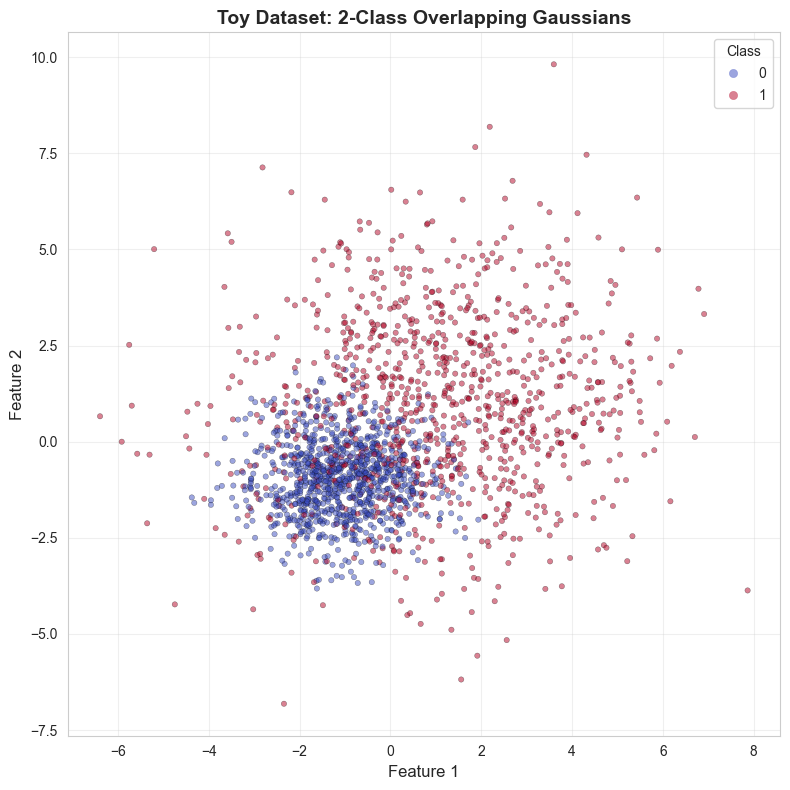

In [2]:
# Generate dataset using the package function
DATASET_OVERLAP = 4.0
X, y, y_onehot = generate_toy_dataset(
    n_samples=15000, overlap=DATASET_OVERLAP, seed=seed
)

# Split into train/test
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
    X, y, y_onehot, test_size=0.9, random_state=seed, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Visualize dataset (subsample if large)
n_plot_points = 2000
if len(X) > n_plot_points:
    from sklearn.model_selection import train_test_split

    _, X_plot, _, y_plot = train_test_split(
        X, y, test_size=n_plot_points / len(X), random_state=seed, stratify=y
    )
else:
    X_plot, y_plot = X, y

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
scatter = ax.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,
    cmap="coolwarm",
    alpha=0.5,
    s=15,
    edgecolors="black",
    linewidths=0.3,
)
ax.set_xlabel("Feature 1", fontsize=12)
ax.set_ylabel("Feature 2", fontsize=12)
ax.set_title(
    "Toy Dataset: 2-Class Overlapping Gaussians", fontsize=14, fontweight="bold"
)
ax.legend(*scatter.legend_elements(), title="Class", loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / "toy_dataset.png", dpi=150, bbox_inches="tight")
plt.show()

## 2. Train Models

We'll train three FNN models:
- **FNN**: Traditional feedforward network (baseline)
- **DropoutFNN**: FNN with Monte Carlo Dropout
- **BayesianFNN**: Bayesian FNN with variational inference



In [ ]:
# Train FNN
print("Training FNN...")
fnn_model = FNN(hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.0)
fnn_params, fnn_history = train_model(
    fnn_model, "FNN", X_train, y_train_onehot, epochs=200, seed=seed
)

fnn_probs, fnn_labels, fnn_metrics, fnn_fop, fnn_mpv = evaluate_model(
    fnn_model,
    fnn_params,
    X_test,
    y_test_onehot,
    n_samples=1,
    model_name="FNN",
    seed=seed,
)
print(fnn_metrics)

Training FNN...
FNN - Epoch 50/200: Loss=0.3287, Acc=0.8592
FNN - Epoch 100/200: Loss=0.3194, Acc=0.8644
FNN - Epoch 150/200: Loss=0.3100, Acc=0.8650
FNN - Epoch 200/200: Loss=0.2987, Acc=0.8696
{'accuracy': 0.8550370335578918, 'ece': 0.035589054226875305, 'mce': 0.06256669759750366, 'brier': 0.22418750822544098}


In [ ]:
# Train DropoutFNN
print("\nTraining DropoutFNN...")
dropout_fnn_model = DropoutFNN(
    hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.2
)
dropout_fnn_params, dropout_fnn_history = train_model(
    dropout_fnn_model, "DropoutFNN", X_train, y_train_onehot, epochs=200, seed=seed
)

# Evaluate DropoutFNN (with MC Dropout)
(
    dropout_fnn_probs,
    dropout_fnn_labels,
    dropout_fnn_metrics,
    dropout_fnn_fop,
    dropout_fnn_mpv,
) = evaluate_model(
    dropout_fnn_model,
    dropout_fnn_params,
    X_test,
    y_test_onehot,
    n_samples=100,
    model_name="DropoutFNN (MC=100)",
    seed=seed,
)
print(dropout_fnn_metrics)


Training DropoutFNN...
DropoutFNN - Epoch 50/200: Loss=0.4165, Acc=0.8251
DropoutFNN - Epoch 100/200: Loss=0.4103, Acc=0.8377
DropoutFNN - Epoch 150/200: Loss=0.4124, Acc=0.8344
DropoutFNN - Epoch 200/200: Loss=0.4011, Acc=0.8247


{'accuracy': 0.8573333024978638,
 'ece': 0.022942665964365005,
 'mce': 0.038385987281799316,
 'brier': 0.21366232633590698}

In [ ]:
# Train BayesianFNN
print("\nTraining BayesianFNN...")
bayesian_fnn_model = BayesianFNN(
    hidden_dims=(32, 32, 32), num_classes=2, beta=0.001, posterior_std_init=0.1
)
bayesian_fnn_params, bayesian_fnn_history = train_model(
    bayesian_fnn_model,
    "BayesianFNN",
    X_train,
    y_train_onehot,
    epochs=200,
    lr=0.00066,
    seed=seed,
)

# Evaluate BayesianFNN (with MC sampling)
(
    bayesian_fnn_probs,
    bayesian_fnn_labels,
    bayesian_fnn_metrics,
    bayesian_fnn_fop,
    bayesian_fnn_mpv,
) = evaluate_model(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test_onehot,
    n_samples=100,
    model_name="BayesianFNN (MC=100)",
    seed=seed,
)
print("\nTraining complete!")
print(bayesian_fnn_metrics)


Training BayesianFNN...
BayesianFNN - Epoch 50/200: Loss=0.7124, Acc=0.8468
BayesianFNN - Epoch 100/200: Loss=0.5709, Acc=0.8525
BayesianFNN - Epoch 150/200: Loss=0.4827, Acc=0.8579
BayesianFNN - Epoch 200/200: Loss=0.4457, Acc=0.8473

Training complete!
{'accuracy': 0.8608888983726501, 'ece': 0.020452750846743584, 'mce': 0.03326934576034546, 'brier': 0.20939649641513824}


In [ ]:
# Evaluate all models (if not already evaluated above)
# These are already evaluated in cells 7-9, but keeping for reference

# Print results as a pretty table
try:
    import pandas as pd

    results_df = pd.DataFrame(
        {
            "Model": ["FNN", "DropoutFNN (MC=100)", "BayesianFNN (MC=100)"],
            "Accuracy": [
                fnn_metrics["accuracy"],
                dropout_fnn_metrics["accuracy"],
                bayesian_fnn_metrics["accuracy"],
            ],
            "ECE": [
                fnn_metrics["ece"],
                dropout_fnn_metrics["ece"],
                bayesian_fnn_metrics["ece"],
            ],
            "MCE": [
                fnn_metrics["mce"],
                dropout_fnn_metrics["mce"],
                bayesian_fnn_metrics["mce"],
            ],
            "Brier Score": [
                fnn_metrics["brier"],
                dropout_fnn_metrics["brier"],
                bayesian_fnn_metrics["brier"],
            ],
        }
    )
    print("\n" + "=" * 70)
    print("Model Evaluation Results")
    print("=" * 70)
    print(results_df.to_string(index=False, float_format="%.4f"))
    print("=" * 70)
except ImportError:
    # Fallback to simple table format if pandas not available
    print("\n" + "=" * 70)
    print("Model Evaluation Results")
    print("=" * 70)
    print(f"{'Model':<25} {'Accuracy':<10} {'ECE':<10} {'MCE':<10} {'Brier Score':<12}")
    print("-" * 70)
    print(
        f"{'FNN':<25} {fnn_metrics['accuracy']:<10.4f} {fnn_metrics['ece']:<10.4f} {fnn_metrics['mce']:<10.4f} {fnn_metrics['brier']:<12.4f}"
    )
    print(
        f"{'DropoutFNN (MC=100)':<25} {dropout_fnn_metrics['accuracy']:<10.4f} {dropout_fnn_metrics['ece']:<10.4f} {dropout_fnn_metrics['mce']:<10.4f} {dropout_fnn_metrics['brier']:<12.4f}"
    )
    print(
        f"{'BayesianFNN (MC=100)':<25} {bayesian_fnn_metrics['accuracy']:<10.4f} {bayesian_fnn_metrics['ece']:<10.4f} {bayesian_fnn_metrics['mce']:<10.4f} {bayesian_fnn_metrics['brier']:<12.4f}"
    )
    print("=" * 70)


Model Evaluation Results
               Model  Accuracy    ECE    MCE  Brier Score
                 FNN    0.8550 0.0356 0.0626       0.2242
 DropoutFNN (MC=100)    0.8573 0.0229 0.0384       0.2137
BayesianFNN (MC=100)    0.8609 0.0205 0.0333       0.2094


## 4. Calibration Analysis

**Calibration** measures how well a model's predicted probabilities match the true empirical frequencies. A well-calibrated model should predict $P(y=1 | \mathbf{x}) = 0.7$ for samples where the true positive rate is approximately 70%.

### Metrics

- **ECE (Expected Calibration Error)**: Average absolute difference between predicted probabilities and empirical frequencies across bins
- **MCE (Maximum Calibration Error)**: Maximum calibration error across all bins
- **Brier Score**: Mean squared error between predicted probabilities and true labels (lower is better)

The calibration curve plots the **fraction of positives** (empirical frequency) against the **mean predicted probability** for each confidence bin. A perfectly calibrated model lies on the diagonal line.



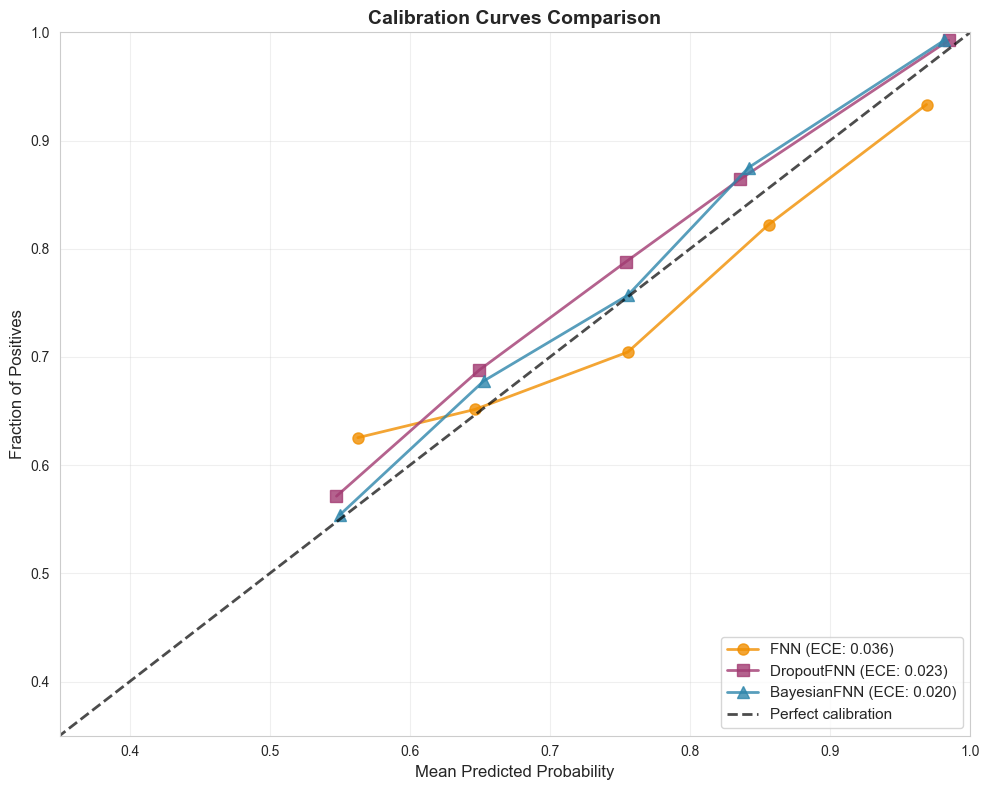

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot calibration curves
ax.plot(
    fnn_mpv,
    fnn_fop,
    "o-",
    label=f"FNN (ECE: {fnn_metrics['ece']:.3f})",
    color="#F18F01",
    linewidth=2,
    markersize=8,
    alpha=0.8,
)
ax.plot(
    dropout_fnn_mpv,
    dropout_fnn_fop,
    "s-",
    label=f"DropoutFNN (ECE: {dropout_fnn_metrics['ece']:.3f})",
    color="#A23B72",
    linewidth=2,
    markersize=8,
    alpha=0.8,
)
ax.plot(
    bayesian_fnn_mpv,
    bayesian_fnn_fop,
    "^-",
    label=f"BayesianFNN (ECE: {bayesian_fnn_metrics['ece']:.3f})",
    color="#2E86AB",
    linewidth=2,
    markersize=8,
    alpha=0.8,
)

# Perfect calibration line
ax.plot([0.0, 1], [0.0, 1], "k--", label="Perfect calibration", linewidth=2, alpha=0.7)

ax.set_xlabel("Mean Predicted Probability", fontsize=12)
ax.set_ylabel("Fraction of Positives", fontsize=12)
ax.set_title("Calibration Curves Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.35, 1])
ax.set_ylim([0.35, 1])
plt.tight_layout()
plt.savefig(
    figures_dir / "calibration_curves_comparison.png", dpi=150, bbox_inches="tight"
)
plt.show()

BayesianFNN - Individual Samples:


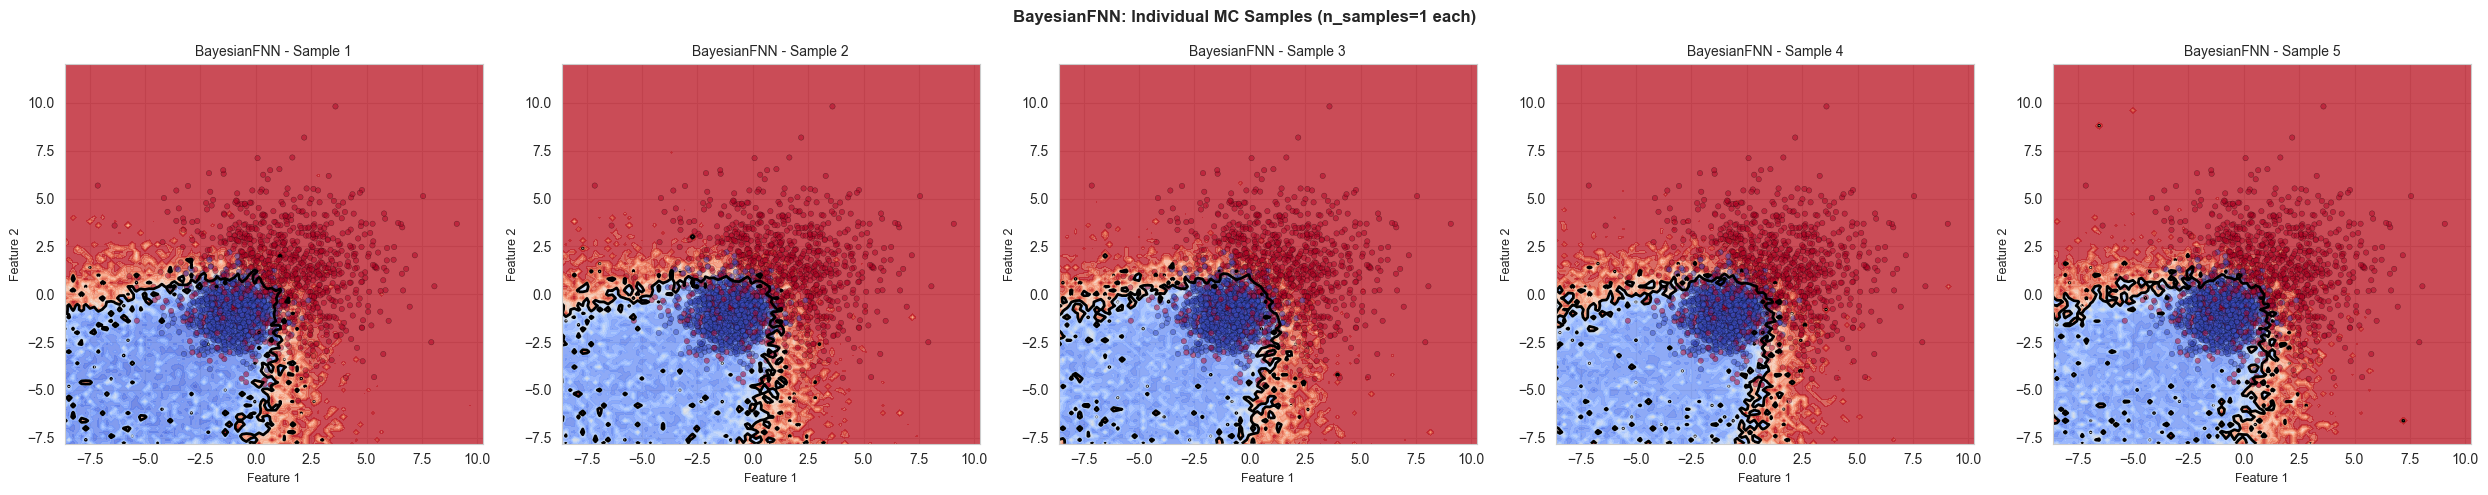


BayesianFNN - Averaged over 100 samples:


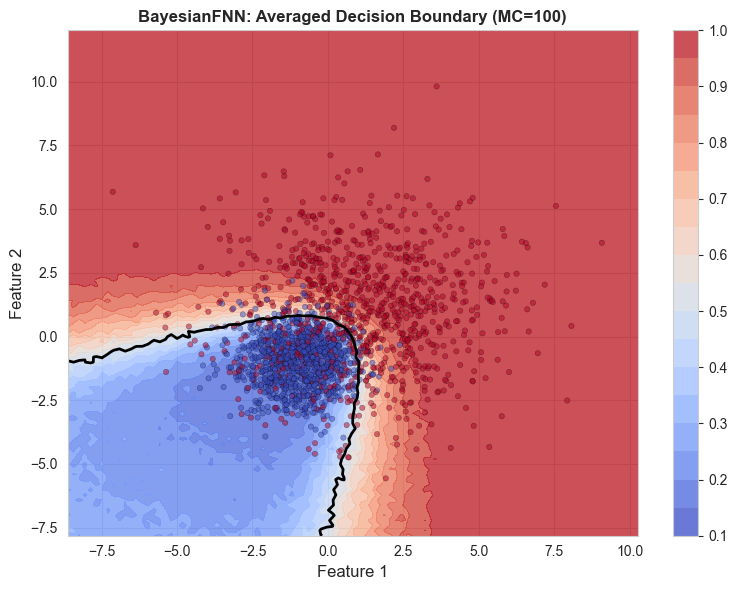

In [17]:
# Check individual predictions (single sample, not averaged) to see if model is non-linear
def plot_single_sample_predictions(
    model, params, X_test, y_test, model_name, n_samples_to_show=5, n_plot_points=2000
):
    """Plot decision boundaries from individual MC samples (not averaged)."""
    # Subsample test set for visualization
    if len(X_test) > n_plot_points:
        from sklearn.model_selection import train_test_split

        _, X_test_plot, _, y_test_plot = train_test_split(
            X_test,
            y_test,
            test_size=n_plot_points / len(X_test),
            random_state=seed,
            stratify=y_test,
        )
    else:
        X_test_plot, y_test_plot = X_test, y_test

    # Create a grid
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_jax = jnp.array(grid_points)

    rng = jax.random.PRNGKey(seed)

    # Get individual sample predictions (not averaged)
    fig, axes = plt.subplots(1, n_samples_to_show, figsize=(5 * n_samples_to_show, 5))
    if n_samples_to_show == 1:
        axes = [axes]

    for i in range(n_samples_to_show):
        rng, eval_rng = jax.random.split(rng)
        # Single sample, no averaging
        probs = model.apply(
            params, inputs=grid_jax, rng=eval_rng, training=False, n_samples=1
        )
        probs_class1 = np.array(probs[:, 1]).reshape(xx.shape)

        contour = axes[i].contourf(
            xx, yy, probs_class1, levels=20, cmap="coolwarm", alpha=0.8
        )
        axes[i].contour(
            xx, yy, probs_class1, levels=[0.5], colors="black", linewidths=2
        )
        axes[i].scatter(
            X_test_plot[:, 0],
            X_test_plot[:, 1],
            c=y_test_plot,
            cmap="coolwarm",
            edgecolors="black",
            linewidths=0.3,
            s=15,
            alpha=0.5,
        )
        axes[i].set_title(f"{model_name} - Sample {i+1}", fontsize=10)
        axes[i].set_xlabel("Feature 1", fontsize=9)
        axes[i].set_ylabel("Feature 2", fontsize=9)

    plt.suptitle(
        f"{model_name}: Individual MC Samples (n_samples=1 each)",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    model_name_safe = model_name.lower().replace(" ", "_")
    plt.savefig(
        figures_dir / f"{model_name_safe}_individual_samples.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()

    # Also plot the averaged version for comparison
    print(f"\n{model_name} - Averaged over 100 samples:")
    rng_avg = jax.random.PRNGKey(seed)
    rng_avg, eval_rng_avg = jax.random.split(rng_avg)
    probs_avg = model.apply(
        params, inputs=grid_jax, rng=eval_rng_avg, training=False, n_samples=100
    )
    probs_class1_avg = np.array(probs_avg[:, 1]).reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    contour = ax.contourf(
        xx, yy, probs_class1_avg, levels=20, cmap="coolwarm", alpha=0.8
    )
    ax.contour(xx, yy, probs_class1_avg, levels=[0.5], colors="black", linewidths=2)
    ax.scatter(
        X_test_plot[:, 0],
        X_test_plot[:, 1],
        c=y_test_plot,
        cmap="coolwarm",
        edgecolors="black",
        linewidths=0.3,
        s=15,
        alpha=0.5,
    )
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(
        f"{model_name}: Averaged Decision Boundary (MC=100)",
        fontsize=12,
        fontweight="bold",
    )
    plt.colorbar(contour, ax=ax)
    plt.tight_layout()
    plt.savefig(
        figures_dir / f"{model_name_safe}_averaged_boundary_mc100.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()


print("BayesianFNN - Individual Samples:")
plot_single_sample_predictions(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples_to_show=5,
)

## 5. Predictive Posterior Visualization

We visualize the **predictive posterior distributions** $P(y=1 | \mathbf{x})$ across the input space. This allows us to:

1. **Inspect decision boundaries**: The black contour line shows where $P(y=1 | \mathbf{x}) = 0.5$ (the decision threshold)
2. **Assess probability contours**: The color gradient shows how confident the model is in different regions
3. **Compare to analytical boundary**: We can visually assess how well each model approximates the Bayes optimal boundary

For Bayesian models and DropoutFNN, we average predictions over multiple Monte Carlo samples to obtain more stable and calibrated probability estimates.



FNN Predictive Posterior:


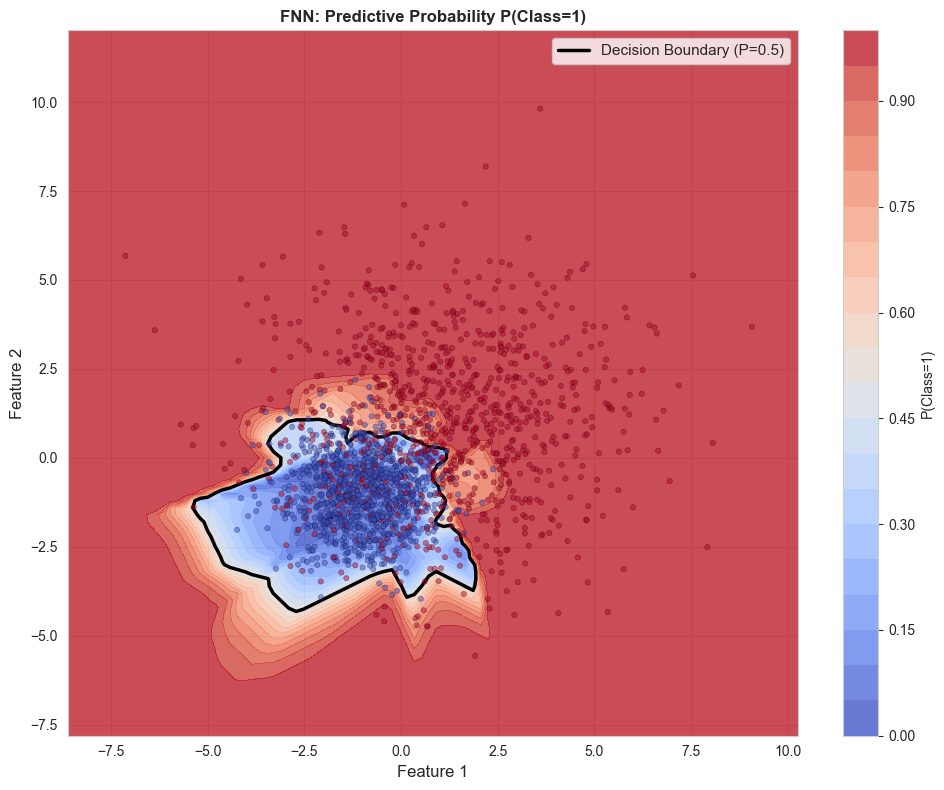


DropoutFNN Predictive Posterior (MC=100):


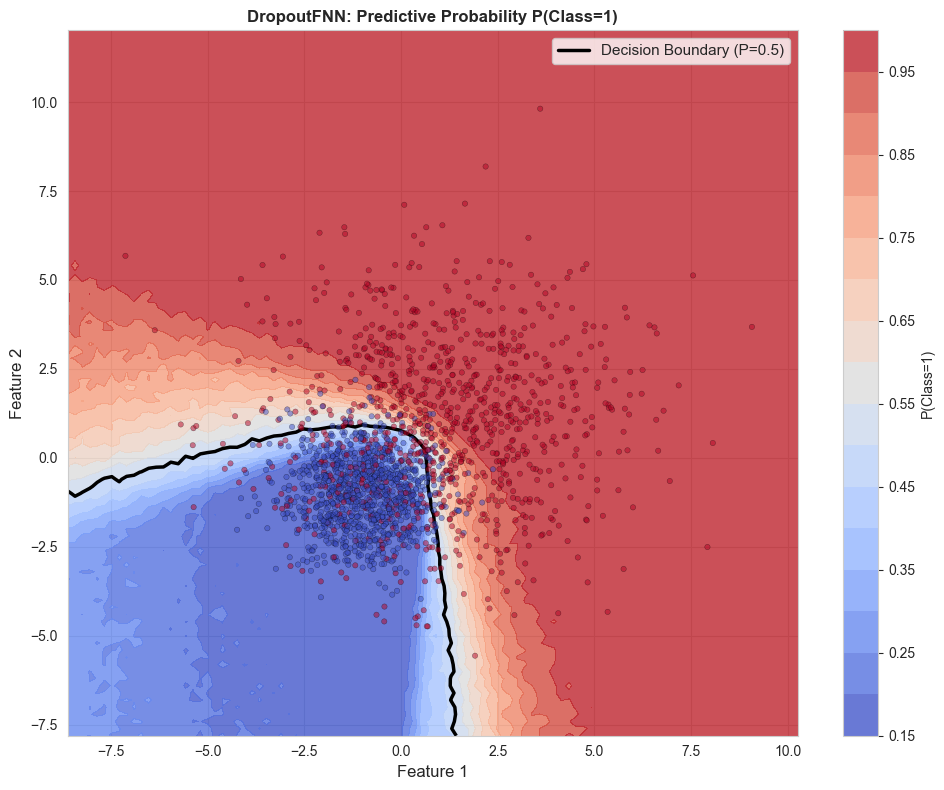


BayesianFNN Predictive Posterior (MC=100):


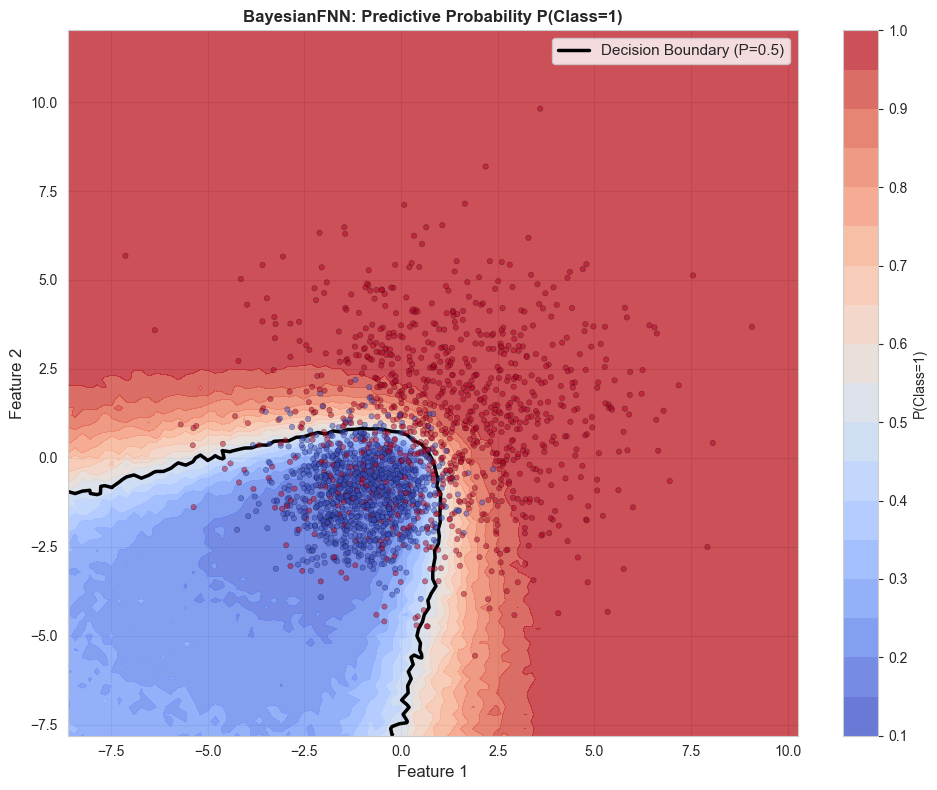

In [ ]:
# Plot for each model
print("FNN Predictive Posterior:")
plot_predictive_posterior(
    fnn_model,
    fnn_params,
    X_test,
    y_test,
    "FNN",
    n_samples=1,
    seed=seed,
    figures_dir=figures_dir,
)

print("\nDropoutFNN Predictive Posterior (MC=100):")
plot_predictive_posterior(
    dropout_fnn_model,
    dropout_fnn_params,
    X_test,
    y_test,
    "DropoutFNN",
    n_samples=100,
    seed=seed,
    figures_dir=figures_dir,
)

print("\nBayesianFNN Predictive Posterior (MC=100):")
plot_predictive_posterior(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples=100,
    seed=seed,
    figures_dir=figures_dir,
)


BayesianFNN Predictive Posterior (MC=10):


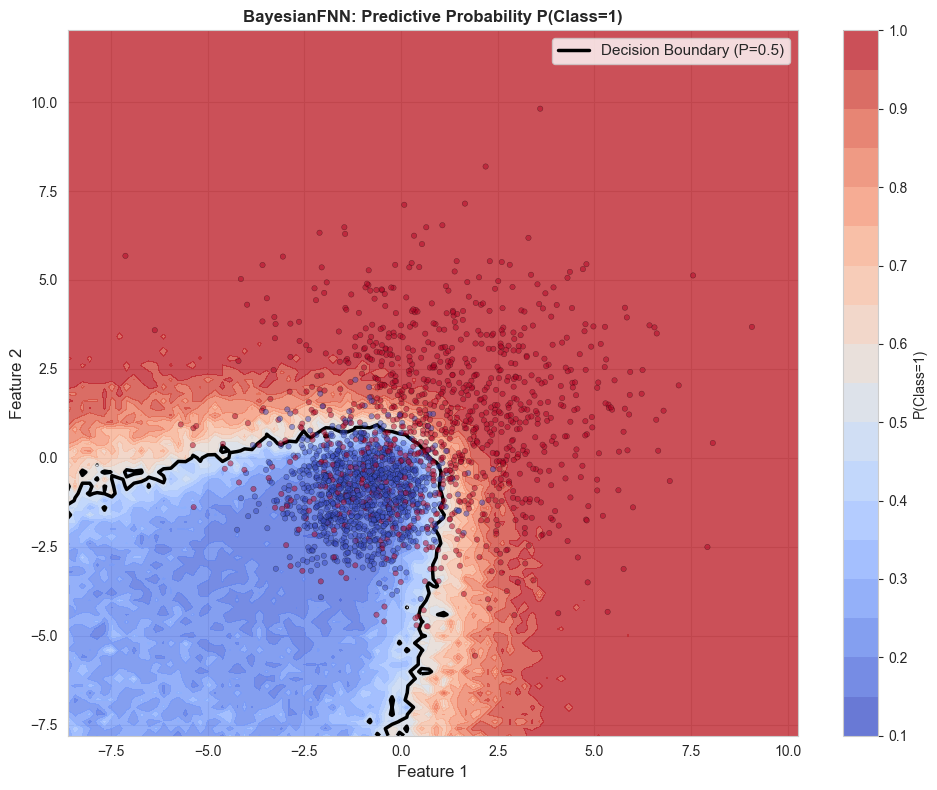


BayesianFNN Predictive Posterior (MC=100):


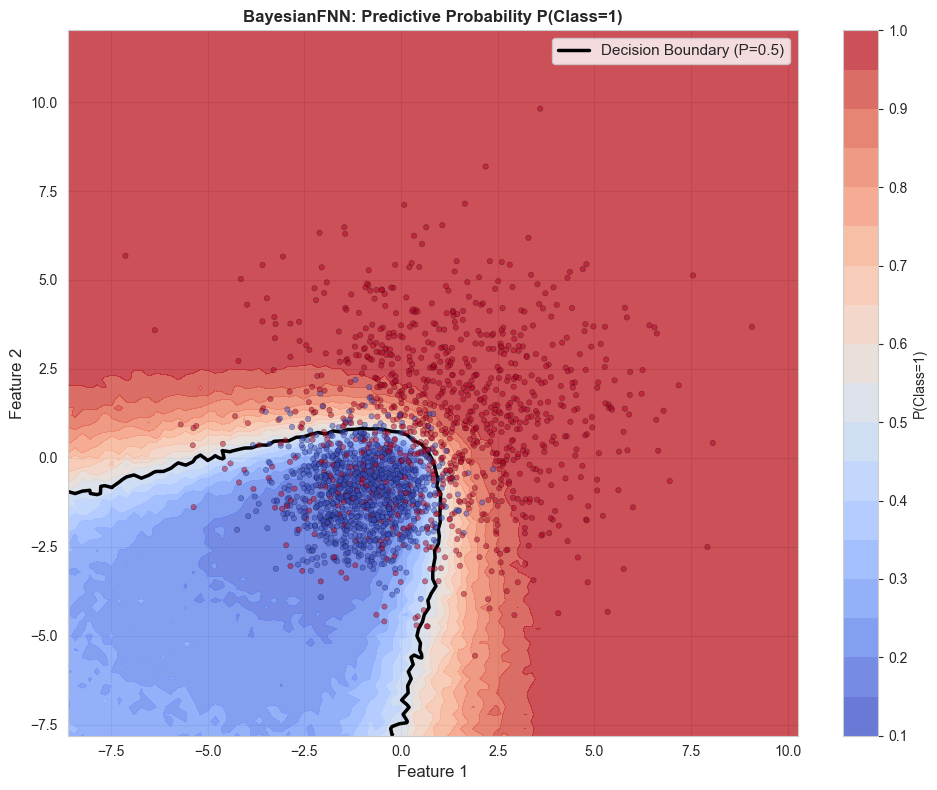


BayesianFNN Predictive Posterior (MC=500):


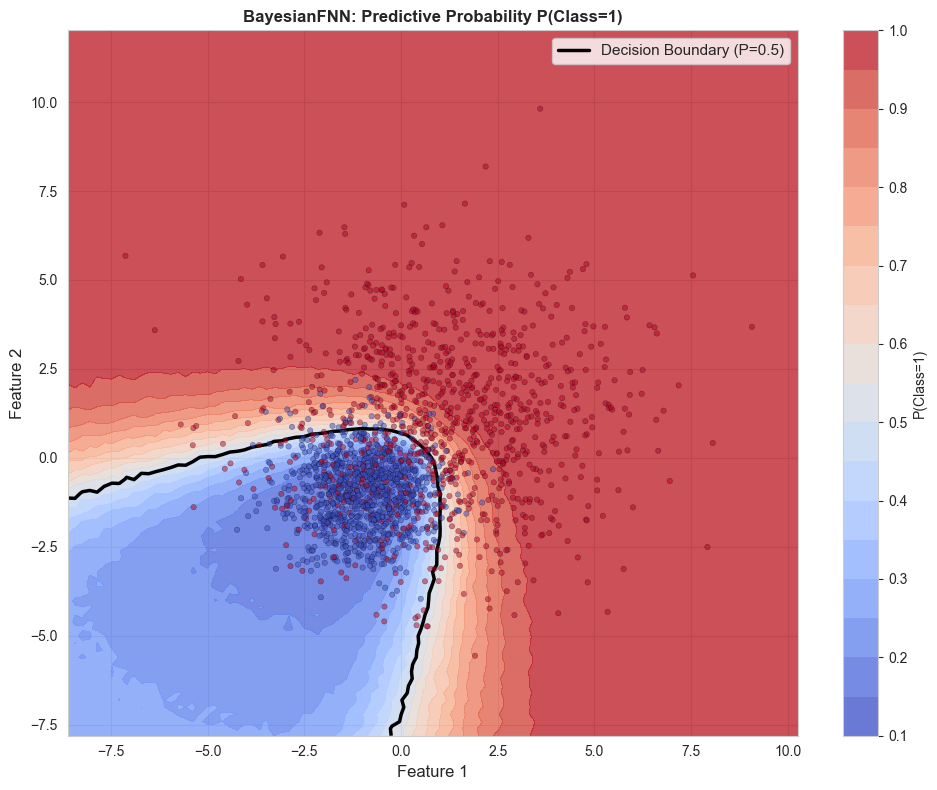

In [ ]:
print("\nBayesianFNN Predictive Posterior (MC=10):")
plot_predictive_posterior(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples=10,
    seed=seed,
    figures_dir=figures_dir,
)

print("\nBayesianFNN Predictive Posterior (MC=100):")
plot_predictive_posterior(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples=100,
    seed=seed,
    figures_dir=figures_dir,
)

print("\nBayesianFNN Predictive Posterior (MC=500):")
plot_predictive_posterior(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples=500,
    seed=seed,
    figures_dir=figures_dir,
)

## 6. Uncertainty Quantification

We visualize **predictive uncertainty** using **entropy** as a measure:

$$H(\mathbf{x}) = -\sum_{c} P(y=c | \mathbf{x}) \log P(y=c | \mathbf{x})$$

Higher entropy indicates higher uncertainty. This visualization helps us understand:

- **Where models are uncertain**: Regions with high entropy (bright yellow/green) correspond to ambiguous decision regions
- **Uncertainty calibration**: Well-calibrated models should show high uncertainty near class boundaries and in regions with overlapping class distributions
- **Comparison across methods**: How different uncertainty quantification approaches (MC Dropout vs. Bayesian inference) differ in their uncertainty estimates

For models with Monte Carlo sampling, we compute entropy from the averaged predictive probabilities over multiple samples.



DropoutFNN Uncertainty (MC=500):


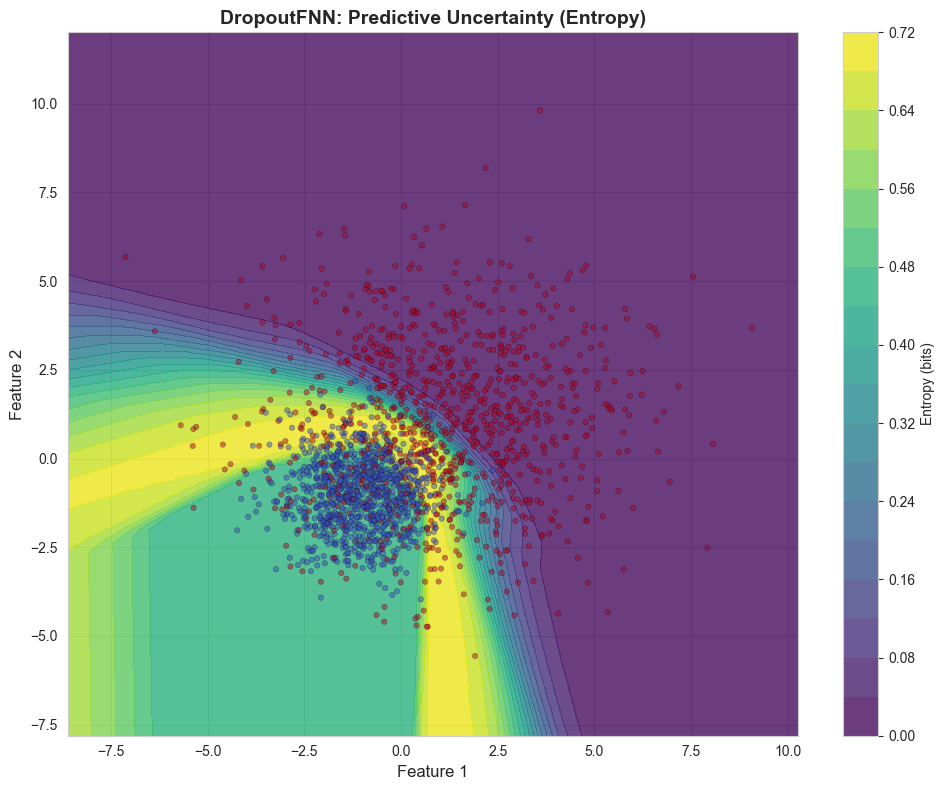


BayesianFNN Uncertainty (MC=500):


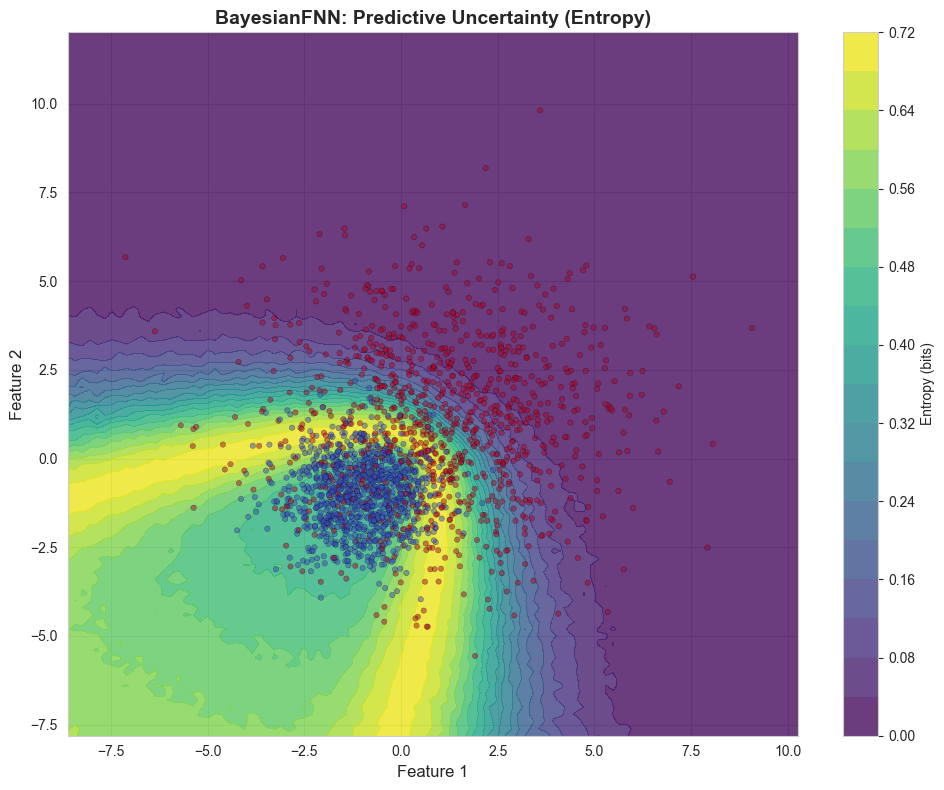

In [ ]:
# Plot uncertainty for models with MC sampling
print("DropoutFNN Uncertainty (MC=100):")
plot_uncertainty(
    dropout_fnn_model,
    dropout_fnn_params,
    X_test,
    y_test,
    "DropoutFNN",
    n_samples=100,
    seed=seed,
    figures_dir=figures_dir,
)

print("\nBayesianFNN Uncertainty (MC=100):")
plot_uncertainty(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test,
    "BayesianFNN",
    n_samples=100,
    seed=seed,
    figures_dir=figures_dir,
)

## Summary

This notebook demonstrates:
1. **Calibration**: How well-calibrated each model is (ECE scores)
2. **Predictive Posteriors**: The decision boundaries and probability contours
3. **Uncertainty**: How each model quantifies uncertainty in its predictions

Key observations:
- Bayesian models typically show better calibration
- MC Dropout and Bayesian models provide uncertainty estimates
- The toy dataset allows us to visualize these properties clearly

